# Binary

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Hàm làm sạch văn bản (giữ nguyên từ code của bạn)
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()  # Chuyển lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Thay dấu câu bằng khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()  # Loại khoảng trắng thừa
    text = word_tokenize(text, format='text')  # Phân từ
    return text

In [23]:
train_df = pd.read_csv('/kaggle/input/cogdis-data/train_cleaned.csv', encoding='utf-8')
val_df = pd.read_csv('/kaggle/input/cogdis-data/val_cleaned.csv', encoding='utf-8')
test_df = pd.read_csv('/kaggle/input/cogdis-data/test_cleaned.csv', encoding='utf-8')

X_train = train_df['clean_text']
y_train = train_df['Label']
X_val = val_df['clean_text']
y_val = val_df['Label']
X_test = test_df['clean_text']
y_test = test_df['Label']

In [24]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Validation Results:
                precision    recall  f1-score   support

 No Distortion       0.60      0.83      0.70       506
Has Distortion       0.93      0.81      0.87      1503

      accuracy                           0.82      2009
     macro avg       0.77      0.82      0.78      2009
  weighted avg       0.85      0.82      0.83      2009

Validation Accuracy: 0.8178
Validation F1-Score: 0.8698


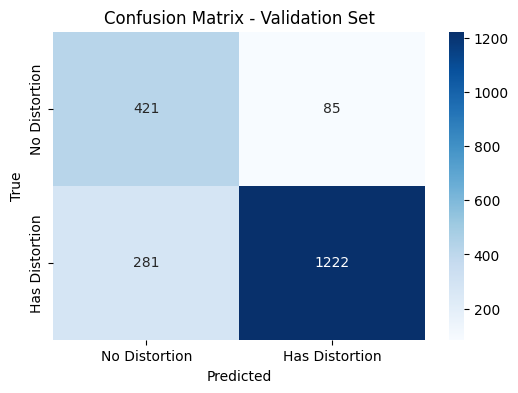

In [31]:
val_preds = model.predict(X_val_tfidf)
print("Validation Results:")
print(classification_report(y_val, val_preds, target_names=['No Distortion', 'Has Distortion']))
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds):.4f}")
print(f"Validation F1-Score: {f1_score(y_val, val_preds, average='binary'):.4f}")

cm_val = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['No Distortion', 'Has Distortion'], yticklabels=['No Distortion', 'Has Distortion'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Test Results:
                precision    recall  f1-score   support

 No Distortion       0.56      0.80      0.66       507
Has Distortion       0.92      0.78      0.85      1503

      accuracy                           0.79      2010
     macro avg       0.74      0.79      0.75      2010
  weighted avg       0.83      0.79      0.80      2010

Test Accuracy: 0.7886
Test F1-Score: 0.8472


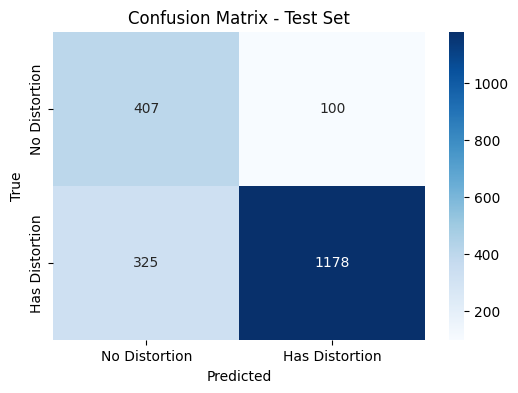

In [28]:
# Đánh giá trên tập test
test_preds = model.predict(X_test_tfidf)
print("\nTest Results:")
print(classification_report(y_test, test_preds, target_names=['No Distortion', 'Has Distortion']))
print(f"Test Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print(f"Test F1-Score: {f1_score(y_test, test_preds, average='binary'):.4f}")

# Vẽ confusion matrix cho test
cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['No Distortion', 'Has Distortion'], yticklabels=['No Distortion', 'Has Distortion'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
# Lưu mô hình và vectorizer
joblib.dump(model, '/kaggle/working/logistic_model.pkl')
joblib.dump(vectorizer, '/kaggle/working/tfidf_vectorizer.pkl')

['/kaggle/working/tfidf_vectorizer.pkl']

# Multi

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Định nghĩa các nhãn cho multi-label classification
labels_columns = [
    'All-or-Nothing Thinking',
    'Overgeneralization',
    'Mental Filter',
    'Disqualifying the Positive',
    'Jumping to Conclusions',
    'Personalization',
    'Emotional Reasoning',
    'Should Statements',
    'Labeling and Mislabeling',
    'Magnification and Minimization'
]

# Load dữ liệu từ CSV
train_df = pd.read_csv("/kaggle/input/cogdis-data/train_cleaned.csv", encoding='utf-8')
val_df = pd.read_csv("/kaggle/input/cogdis-data/val_cleaned.csv", encoding='utf-8')
test_df = pd.read_csv("/kaggle/input/cogdis-data/test_cleaned.csv", encoding='utf-8')

# Kiểm tra cột cần thiết
required_columns = ['clean_text'] + labels_columns
for df, name in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Dataset {name}.csv thiếu cột: {required_columns}")

In [4]:
# Chuẩn bị dữ liệu: Lấy text và nhãn multi-label
X_train = train_df['clean_text'].values
y_train = train_df[labels_columns].values

X_val = val_df['clean_text'].values
y_val = val_df[labels_columns].values

X_test = test_df['clean_text'].values
y_test = test_df[labels_columns].values

# Vectorize văn bản sử dụng TF-IDF (tương tự baseline Logistic Regression cho detection)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [5]:
# Huấn luyện mô hình Logistic Regression với OneVsRestClassifier cho multi-label
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
model.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000))

In [6]:
# Dự đoán trên test set
y_pred = model.predict(X_test_vec)

# Đánh giá tổng thể
print("\nClassification Report (Multi-label):")
print(classification_report(y_test, y_pred, target_names=labels_columns, zero_division=0))


Classification Report (Multi-label):
                                precision    recall  f1-score   support

       All-or-Nothing Thinking       0.20      0.60      0.30       125
            Overgeneralization       0.26      0.61      0.36       161
                 Mental Filter       0.38      0.72      0.50       108
    Disqualifying the Positive       0.83      0.92      0.87       119
        Jumping to Conclusions       0.45      0.73      0.56       314
               Personalization       0.29      0.72      0.41       107
           Emotional Reasoning       0.22      0.59      0.32       136
             Should Statements       0.65      0.79      0.71        98
      Labeling and Mislabeling       0.60      0.78      0.68       302
Magnification and Minimization       0.42      0.73      0.54       113

                     micro avg       0.39      0.72      0.51      1583
                     macro avg       0.43      0.72      0.52      1583
                  weight

In [7]:
# Tính F1-score micro, macro, weighted
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

print("\nOverall Metrics:")
print(f"Accuracy (Hamming Loss-based): {accuracy_score(y_test, y_pred)}")  # Hamming accuracy cho multi-label
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"Precision Macro: {precision_macro:.4f}")
print(f"Recall Macro: {recall_macro:.4f}")


Overall Metrics:
Accuracy (Hamming Loss-based): 0.37213930348258706
F1 Micro: 0.5054
F1 Macro: 0.5246
F1 Weighted: 0.5374
Precision Macro: 0.4293
Recall Macro: 0.7189


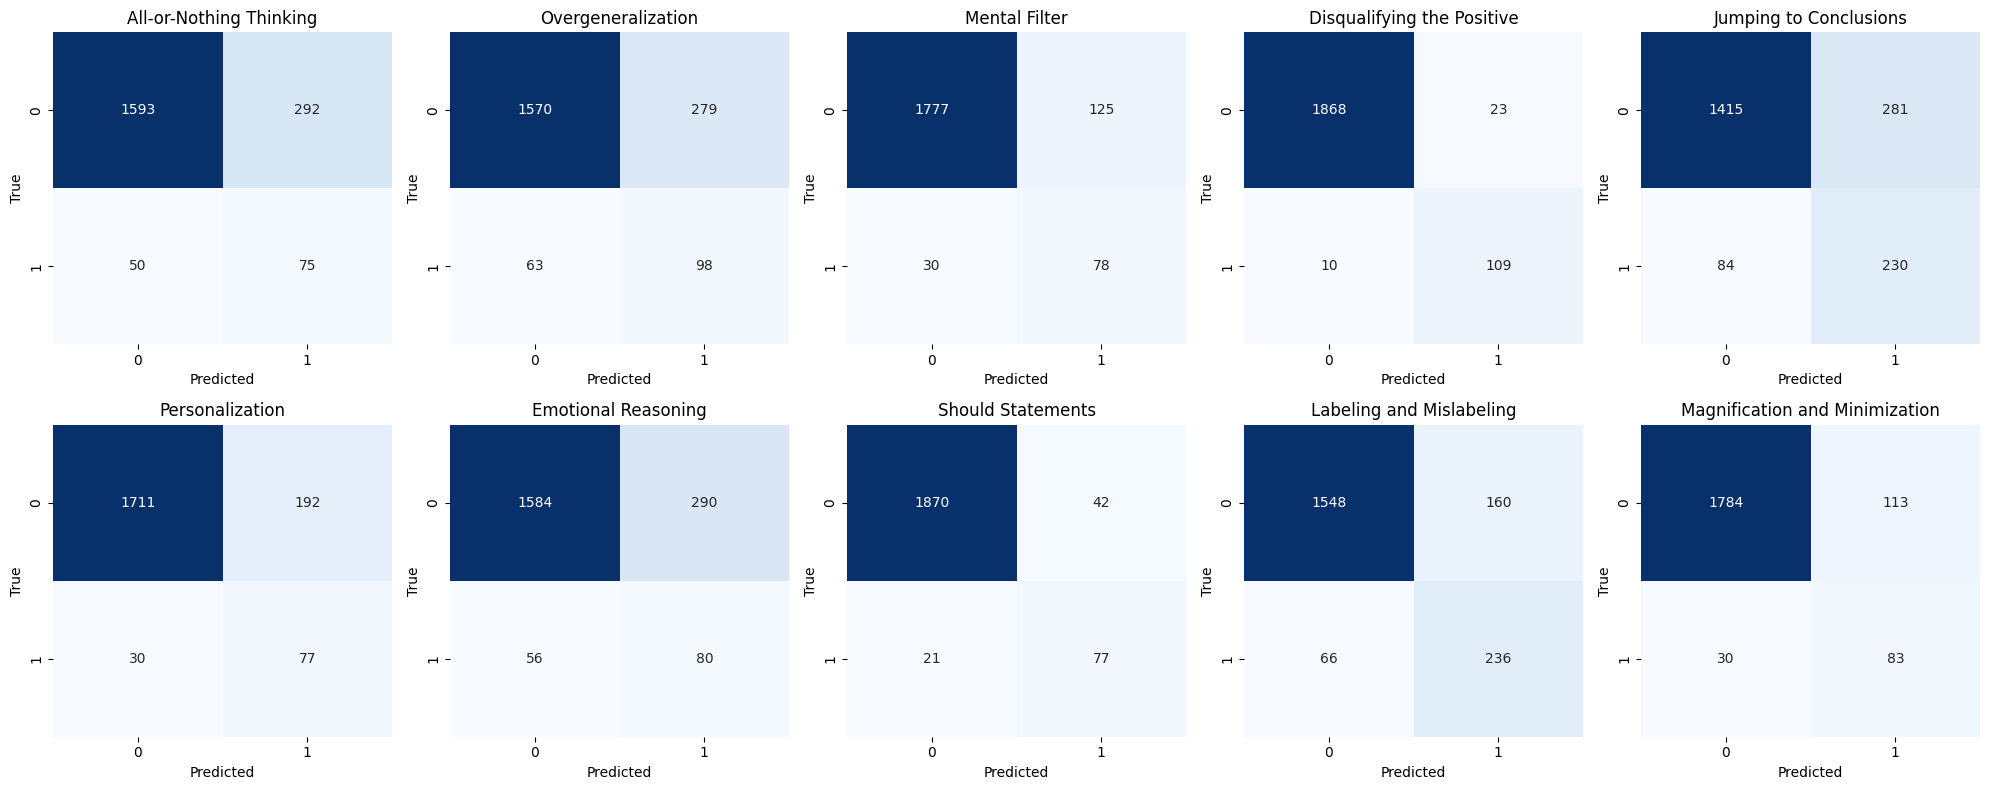

In [8]:
# Vẽ confusion matrix cho từng label (optional, để xem chi tiết từng class)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()
for i, label in enumerate(labels_columns):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(label)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()